In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

/home/homeros/miniconda3/envs/rcnn/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41481 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41481/status,
Dashboard: http://127.0.0.1:41481/status,Workers: 5
Total threads: 20,Total memory: 31.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44313,Workers: 5
Dashboard: http://127.0.0.1:41481/status,Total threads: 20
Started: Just now,Total memory: 31.04 GiB
Comm: tcp://127.0.0.1:37853,Total threads: 4
Dashboard: http://127.0.0.1:34531/status,Memory: 6.21 GiB
Nanny: tcp://127.0.0.1:33131,


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 83.2 ms, sys: 11.4 ms, total: 94.6 ms
Wall time: 94.9 ms


In [5]:
%%time

index=0
before = get_ddf_shape(bbdd_completa)
print(before)

index+=1
print(index)
# 1 Error fix. # 2019 gener, febrer and marc have the status reversed
cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))
bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))
index+=1
print(index)
# 2 Remove not needed status, manitenance, planned. open = 0, closed = 1 
cond = (bbdd_completa['status'].isin([2.0,3.0]))
bbdd_completa = bbdd_completa.mask(cond, 1.0)
bbdd_completa = bbdd_completa.dropna(subset=['status'])
index+=1
print(index)
# 3 Remove data from 2020
cond = (bbdd_completa['year'].isin([2020]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['year'])
index+=1
print(index)
# 4 2019 to 2020 to have continuos data 
cond = (bbdd_completa['year'].isin([2019]))
bbdd_completa['year'] = bbdd_completa['year'].mask(cond, bbdd_completa['year']+1)
index+=1
print(index)
# 5 status reversed 
bbdd_completa['status'] = (bbdd_completa['status'] + 1)%2
index+=1
print(index)
# 6 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_installed'])
index+=1
print(index)
# 7 Column has all ones
bbdd_completa = bbdd_completa.drop(columns=['is_charging_station'])
index+=1
print(index)
# 8 Remove row where status = closed and is renting and is returning
cond = (bbdd_completa['status'].isin([0.0])) & (bbdd_completa['is_renting'].isin([1.0])) & (bbdd_completa['is_returning'].isin([1.0]))
bbdd_completa = bbdd_completa.mask(cond, np.nan)
bbdd_completa = bbdd_completa.dropna(subset=['status'])

after = get_ddf_shape(bbdd_completa)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(12419994, 23)
1
2
3
4
5
6
7
8
(11984228, 21)
Changes to dataframe durinf preprocessing
dropeed -435766 rows
dropped -2 columns
CPU times: user 3.85 s, sys: 407 ms, total: 4.26 s
Wall time: 17.6 s


In [6]:
%%time

unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2020])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

year
2020.0    [1.0, 320.0, 319.0, 318.0, 317.0, 316.0, 315.0...
2021.0    [1.0, 271.0, 400.0, 510.0, 26.0, 270.0, 269.0,...
2022.0    [1.0, 380.0, 28.0, 379.0, 378.0, 377.0, 376.0,...
Name: station_id, dtype: object
2020.0 (410,)
2021.0 (509,)
2022.0 (510,)
408
CPU times: user 1.26 s, sys: 171 ms, total: 1.44 s
Wall time: 10.4 s


In [7]:
%%time

before = get_ddf_shape(filtered_bbdd)
print(before)

filtered_bbdd = filtered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(filtered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(10194539, 21)
(10100285, 21)
Changes to dataframe durinf preprocessing
dropeed -94254 rows
dropped 00 columns
CPU times: user 6.65 s, sys: 682 ms, total: 7.33 s
Wall time: 27.9 s


In [8]:
%%time

before = get_ddf_shape(nonfiltered_bbdd)
print(before)

nonfiltered_bbdd = nonfiltered_bbdd.drop_duplicates(subset=['timestamp', 'station_id'], keep='last')

after = get_ddf_shape(nonfiltered_bbdd)
print(after)

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(after[0]-before[0]):02d} rows')
print(f'dropped {(after[1]-before[1]):02d} columns')

(1789689, 21)
(1769381, 21)
Changes to dataframe durinf preprocessing
dropeed -20308 rows
dropped 00 columns
CPU times: user 6.47 s, sys: 589 ms, total: 7.06 s
Wall time: 25 s


# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [9]:
import os
import csv
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

2023-06-02 03:58:46.781260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-02 03:58:47.054596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 03:58:48.375469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

DATA_DIR = 'dades'
OUTPUT_DIR = './'

In [10]:
class Config:
    num_attribs0 = ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = ['month', 'dayofweek', 'day', 'dayofyear', 'hour' ]
    cat_attribs1 = ['station_id']
    gen_attribs0 = ['status', 'is_renting', 'is_returning']
    target_col = ['ctx0']
    
    epochs=5
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    

In [11]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
config=Config()
seed_everything(config.seed)

In [12]:
filtered_bbdd.columns

Index(['station_id', 'num_docks_available', 'num_bikes_available', 'status',
       'timestamp', 'is_renting', 'is_returning',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [13]:

def build_preprocessor(config): 
    
    num_attribs0 = config.num_attribs0 # ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = config.cat_attribs0 #['month', 'dayofweek', 'day', 'dayofyear', 'hour' ]
    cat_attribs1 = config.cat_attribs1 #['station_id']
    gen_attribs0 = config.gen_attribs0 #['status', 'is_renting', 'is_returning']
    
    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder())),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
            ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

def apply_pipeline(config, x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = build_preprocessor(config)

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test


In [13]:
%%time 

x_train, x_test, y_train, y_test = filtered_bbdd.compute().copy(),nonfiltered_bbdd.compute().copy(), filtered_bbdd.ctx0.compute().copy(), nonfiltered_bbdd.ctx0.compute().copy()

CPU times: user 6.42 s, sys: 3.4 s, total: 9.82 s
Wall time: 53.9 s


In [15]:
%%time 

x_train_prepared,x_test_prepared,y_train,y_test = apply_pipeline(config, x_train,x_test,y_train,y_test)

x_train_prepared: (10100285, 421) y_train:  (10100285,)
x_test_prepared: (1769381, 421) y_test:  (1769381,)
CPU times: user 11.1 s, sys: 2.04 s, total: 13.2 s
Wall time: 12 s


In [25]:
%%time 

lin_reg = LinearRegression()
cross_val_evaluation(lin_reg,x_train_prepared, y_train,'Linear Regression')
#  Linear Regression
# Scores: [0.86876116 0.85690033 0.83716171 0.82008556 0.8135665 ]
# Mean: 0.8392950517172396
# Standard deviation: 0.021041440859117303


  Linear Regression
Scores: [0.86899924 0.85701564 0.83715041 0.82014689 0.81363575]
Mean: 0.839389585913087
Standard deviation: 0.021099594121137856
CPU times: user 1min 17s, sys: 3min 33s, total: 4min 51s
Wall time: 45.1 s



Training time: 0.266 s
----- EVALUATION ON VAL SET ------
MSE: 0.012851207053139834
RMSE 0.11336316444568682
MAE: 0.07415067021244647
R^2:  0.8436992630819116



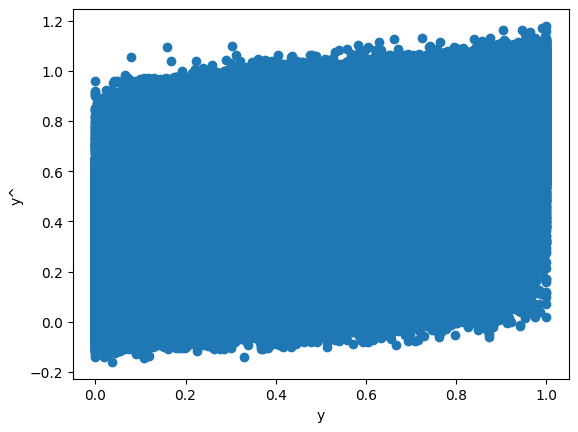


Testing time: 0.037 s
----- EVALUATION ON VAL SET ------
MSE: 0.009087157054815241
RMSE 0.09532658105069772
MAE: 0.06325160105754518
R^2:  0.8691530607348313



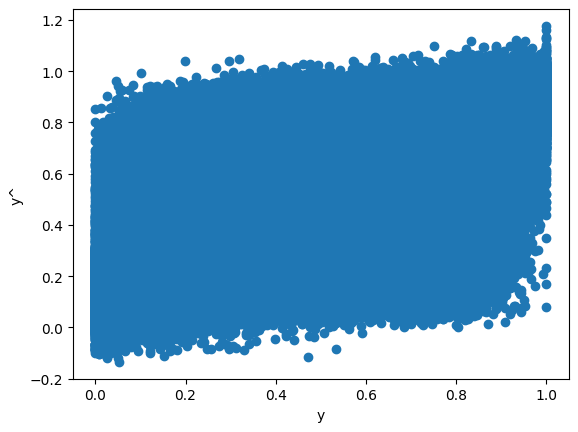

y_hat_t    [0.2245009591113864, 0.08555091990529551, 0.06...
mse_t                                               0.012851
rmse_t                                              0.113363
mae_t                                               0.074151
r2_t                                                0.843699
y_hat_v    [0.5109977935437623, 0.9106963666793366, 0.900...
mse_v                                               0.009087
rmse_v                                              0.095327
mae_v                                               0.063252
r2_v                                                0.869153
dtype: object

In [28]:
lin_reg.fit(x_train_prepared,y_train)
test_model(lin_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [26]:
%%time 

ridge_reg = linear_model.Ridge(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(ridge_reg,x_train_prepared, y_train,'Ridge Regression')
#   Ridge Regression
# Scores: [0.86875691 0.85689315 0.83715539 0.82008539 0.81356727]
# Mean: 0.839291622628996
# Standard deviation: 0.021039020876520598


  Ridge Regression
Scores: [0.86899909 0.85701562 0.83714803 0.82015689 0.81364697]
Mean: 0.8393933193134504
Standard deviation: 0.021095035859136448
CPU times: user 54.9 s, sys: 1min 45s, total: 2min 39s
Wall time: 35.3 s



Training time: 0.238 s
----- EVALUATION ON VAL SET ------
MSE: 0.01285151626405725
RMSE 0.1133645282443201
MAE: 0.07414802061613243
R^2:  0.8436955023539072



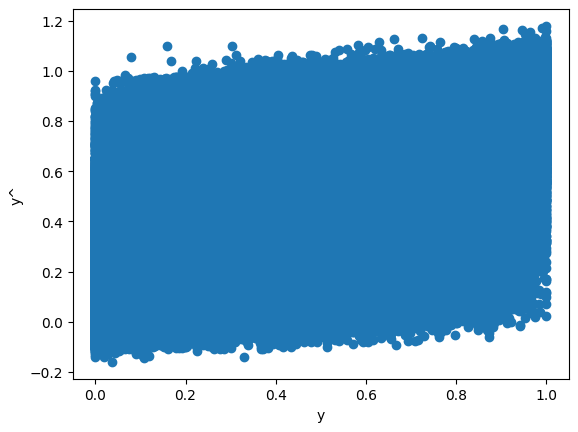


Testing time: 0.04 s
----- EVALUATION ON VAL SET ------
MSE: 0.009086590098364572
RMSE 0.09532360724586839
MAE: 0.0632452709414458
R^2:  0.8691612244009614



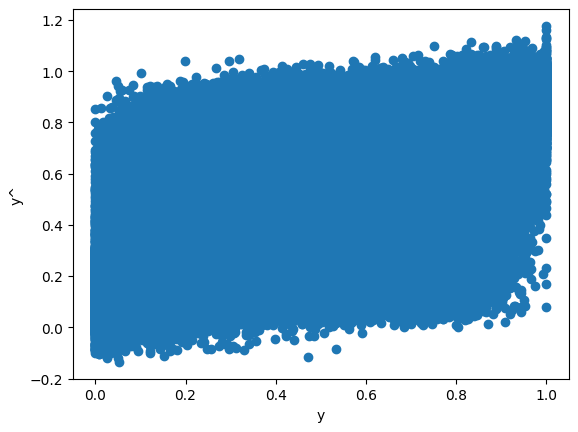

y_hat_t    [0.22437869485849465, 0.08542186265954305, 0.0...
mse_t                                               0.012852
rmse_t                                              0.113365
mae_t                                               0.074148
r2_t                                                0.843696
y_hat_v    [0.5108043505311364, 0.910513429837106, 0.8999...
mse_v                                               0.009087
rmse_v                                              0.095324
mae_v                                               0.063245
r2_v                                                0.869161
dtype: object

In [29]:
ridge_reg.fit(x_train_prepared,y_train)
test_model(ridge_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [27]:
%%time 

lasso_reg = linear_model.Lasso(alpha=0.01) # Create a Ridge regressor
cross_val_evaluation(lasso_reg,x_train_prepared, y_train,'Lasso Regression')
#   Lasso Regression
# Scores: [0.85542452 0.844529   0.82666133 0.81003802 0.80356838]
# Mean: 0.8280442480533837
# Standard deviation: 0.0197313499648892
# CPU times: user 2min 14s, sys: 3min 2s, total: 5min 16s
# Wall time: 1min 28s


  Lasso Regression
Scores: [0.85545516 0.84454683 0.82664457 0.81002738 0.80356815]
Mean: 0.8280484175862514
Standard deviation: 0.019745071952468194
CPU times: user 1min 21s, sys: 13.3 s, total: 1min 35s
Wall time: 1min 14s



Training time: 0.197 s
----- EVALUATION ON VAL SET ------
MSE: 0.013817252178934755
RMSE 0.1175468084591613
MAE: 0.07919499964500935
R^2:  0.8319498947592697



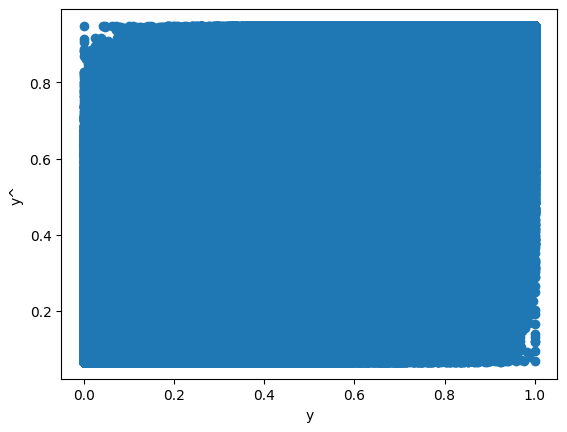


Testing time: 0.023 s
----- EVALUATION ON VAL SET ------
MSE: 0.009560732448613518
RMSE 0.09777899799350329
MAE: 0.06455680129847247
R^2:  0.862333998357455



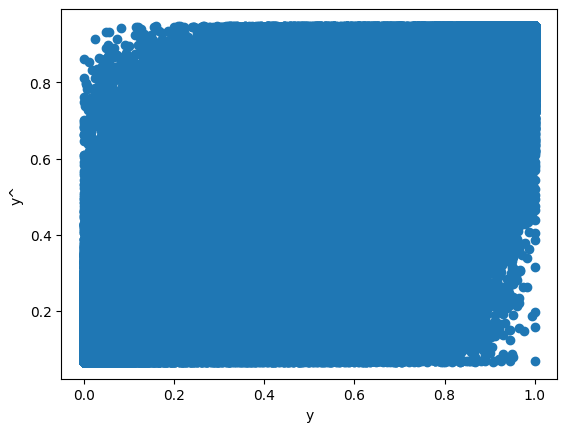

y_hat_t    [0.2257529985885911, 0.08524942634927435, 0.06...
mse_t                                               0.013817
rmse_t                                              0.117547
mae_t                                               0.079195
r2_t                                                 0.83195
y_hat_v    [0.5050255310642701, 0.9073109647494744, 0.900...
mse_v                                               0.009561
rmse_v                                              0.097779
mae_v                                               0.064557
r2_v                                                0.862334
dtype: object

In [30]:
lasso_reg.fit(x_train_prepared,y_train)
test_model(lasso_reg, x_train_prepared, y_train, x_test_prepared, y_test)

In [31]:
names = [ i for i in range(x_train_prepared.shape[1])]

In [32]:
coefs_lin_reg = pd.Series(np.abs(lin_reg.coef_), names).sort_values()
coefs_ridge_reg = pd.Series(np.abs(ridge_reg.coef_), names).sort_values()
coefs_lasso_reg = pd.Series(np.abs(lasso_reg.coef_), names).sort_values()

<Axes: title={'center': 'coefs_lasso'}>

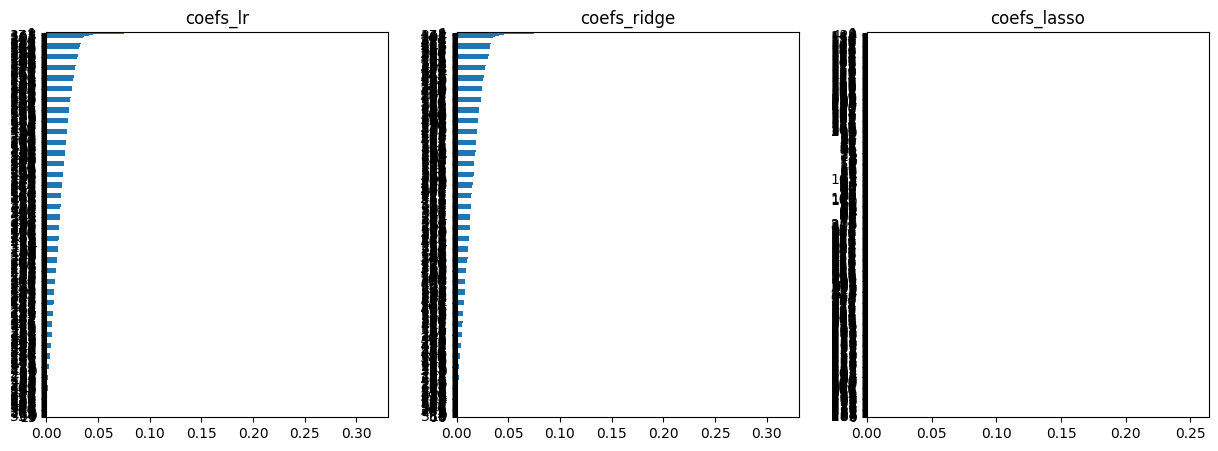

In [33]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

coefs_lin_reg.plot(kind="barh", title='coefs_lr', ax=ax1)
coefs_ridge_reg.plot(kind="barh", title='coefs_ridge', ax=ax2)
coefs_lasso_reg.plot(kind="barh", title='coefs_lasso', ax=ax3)



In [34]:
n_alphas = 50
alphas = np.logspace(-1, 1, n_alphas)

In [37]:
%%time 

coefs_ridge = []
r2_ridge = []
for l in tqdm(alphas):
    regr_ridge = linear_model.Ridge(alpha=l) # Create a Ridge regressor
    regr_ridge.fit(x_train_prepared, y_train)  # Perform the fitting
    coefs_ridge.append(regr_ridge.coef_)
    r2_ridge.append(regr_ridge.score(x_test_prepared,y_test))

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 10min 21s, sys: 17min 5s, total: 27min 26s
Wall time: 6min 36s


In [39]:
%%time 

coefs_lasso = []
r2_lasso = []
for l in tqdm(alphas):
    regr_lasso = linear_model.Lasso(alpha=l,tol=0.001) # Create a Ridge regressor
    regr_lasso.fit(x_train_prepared, y_train)  # Perform the fitting
    coefs_lasso.append(regr_lasso.coef_)
    r2_lasso.append(regr_lasso.score(x_test_prepared,y_test))

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 11min 26s, sys: 2min, total: 13min 27s
Wall time: 10min 11s


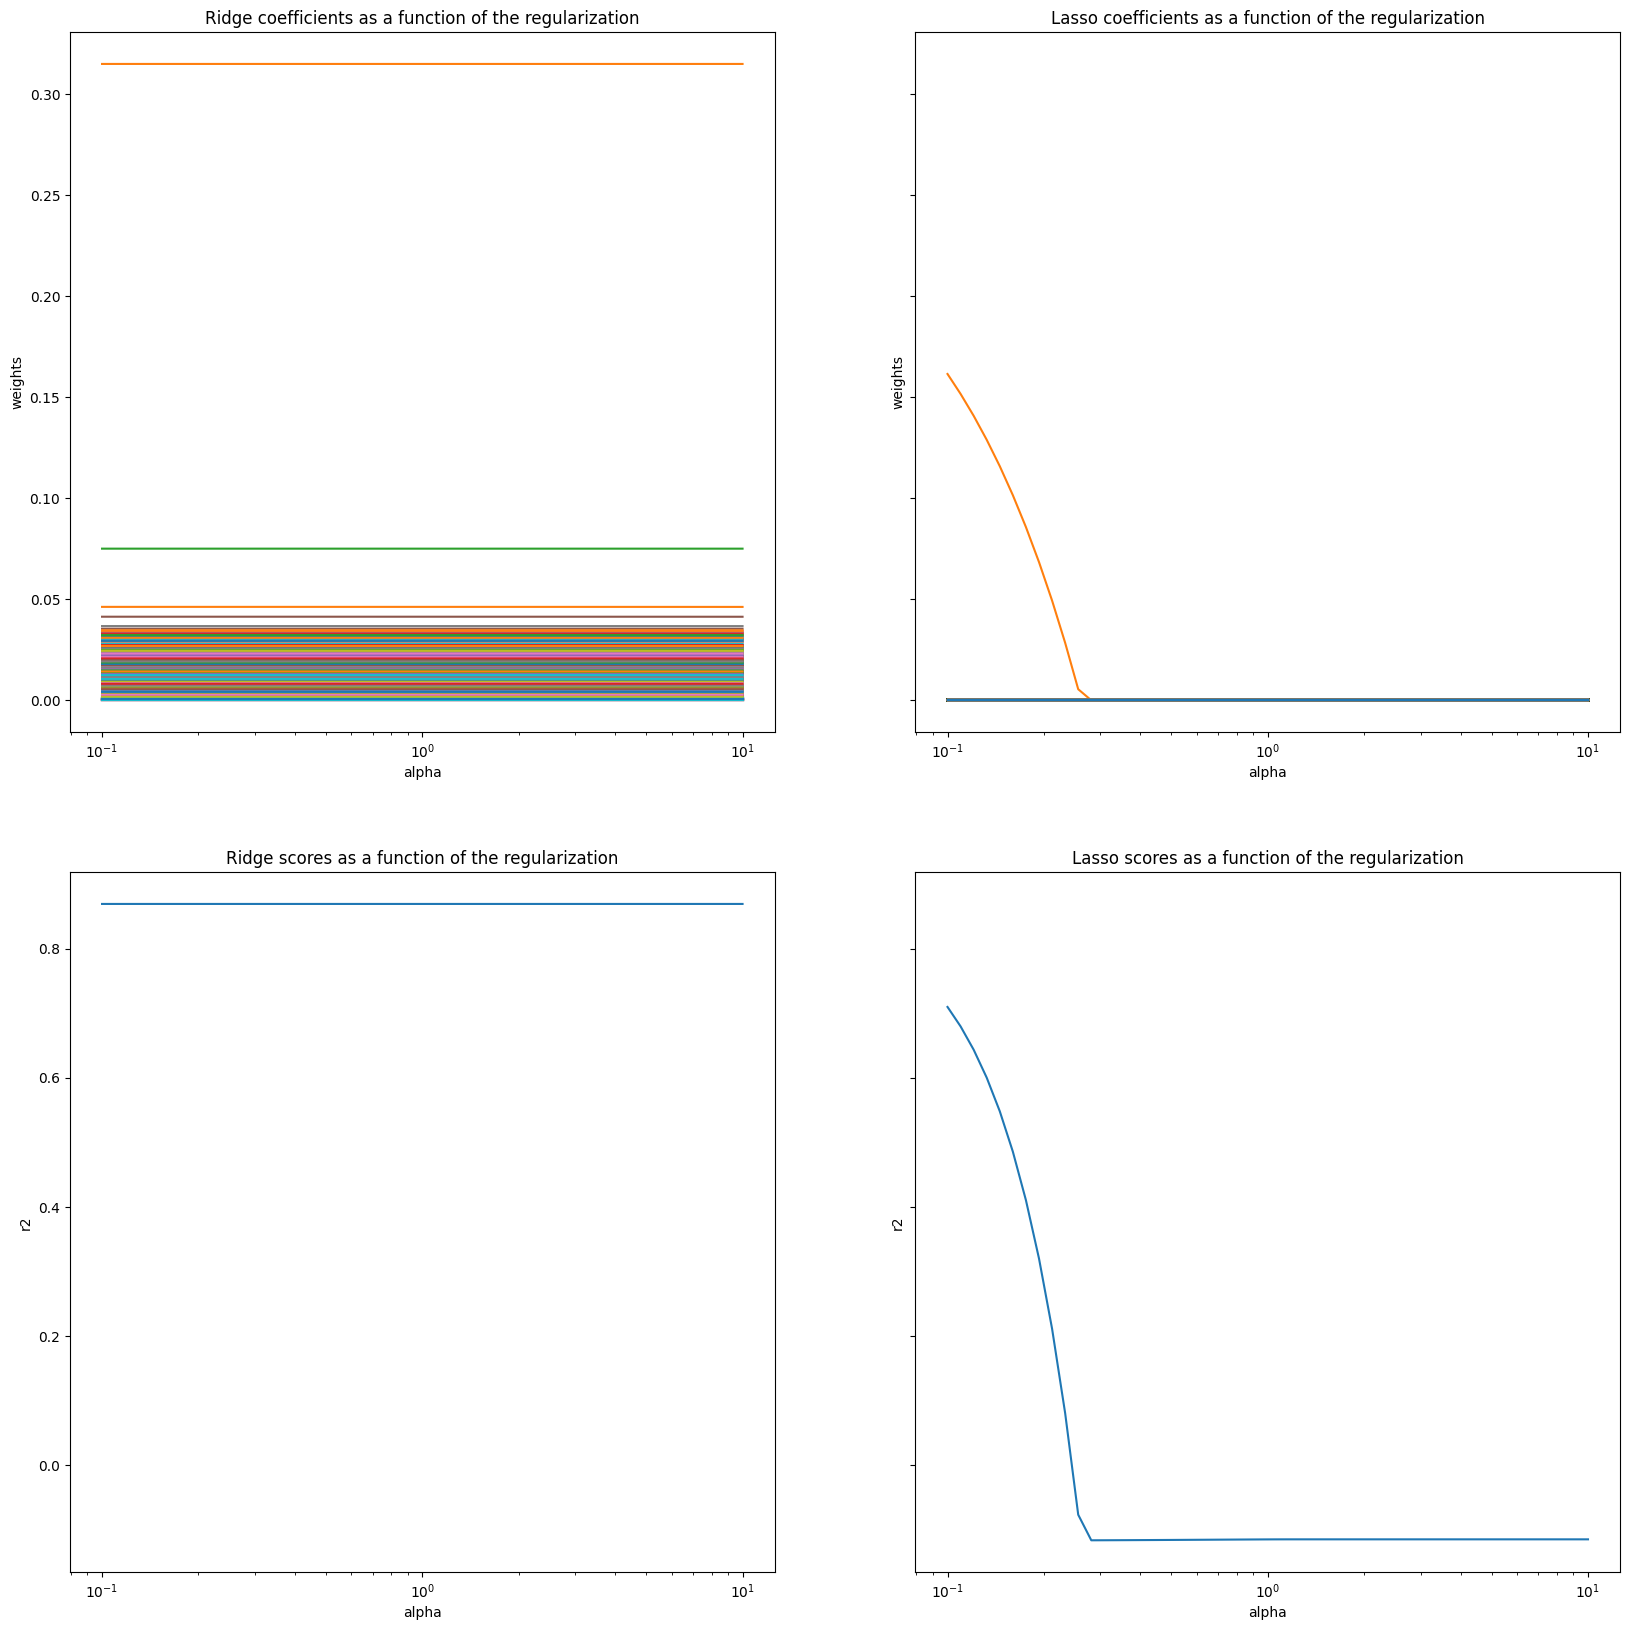

In [40]:
# Display results

fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey='row')

axs[0,0].plot(alphas, np.abs(coefs_ridge))
axs[0,0].set_xscale('log')
axs[0,0].set_title('Ridge coefficients as a function of the regularization')
axs[0,0].axis('tight')
axs[0,0].set_xlabel('alpha')
axs[0,0].set_ylabel('weights')
#axs[0,0].legend(names)

axs[0,1].plot(alphas, np.abs(coefs_lasso))
axs[0,1].set_xscale('log')
axs[0,1].set_title('Lasso coefficients as a function of the regularization')
axs[0,1].axis('tight')
axs[0,1].set_xlabel('alpha')
axs[0,1].set_ylabel('weights')
#axs[0,1].legend(names)

axs[1,0].plot(alphas, r2_ridge)
axs[1,0].set_xscale('log')
axs[1,0].set_title('Ridge scores as a function of the regularization')
axs[1,0].axis('tight')
axs[1,0].set_xlabel('alpha')
axs[1,0].set_ylabel('r2')

axs[1,1].plot(alphas, r2_lasso)
axs[1,1].set_xscale('log')
axs[1,1].set_title('Lasso scores as a function of the regularization')
axs[1,1].axis('tight')
axs[1,1].set_xlabel('alpha')
axs[1,1].set_ylabel('r2')


plt.show()


In [41]:

# Find optimal alphas
best_r2_ridge = max(r2_ridge)
max_index_ridge = r2_ridge.index(best_r2_ridge)
best_alpha_ridge = alphas[max_index_ridge]
print('Ridge')
print(max_index_ridge, best_alpha_ridge, best_r2_ridge)

best_r2_lasso = max(r2_lasso)
max_index_lasso = r2_lasso.index(best_r2_lasso)
best_alpha_lasso = alphas[max_index_lasso]
print('Lasso')
print(max_index_lasso, best_alpha_lasso, best_r2_lasso)



Ridge
49 10.0 0.8691629642076816
Lasso
0 0.09999999999999999 0.7096394328354863


## NN 

In [14]:
import tensorflow as tf
from tensorflow import keras
print(keras.__version__)
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0
2.12.0
/device:GPU:0


2023-06-02 03:59:44.830000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 9726 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [15]:


from tensorflow.python.client import device_lib
device_lib.list_local_devices()



2023-06-02 03:59:44.844730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 9726 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17582008966107169534
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10198646784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13241992620986869268
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [16]:


# clear previous session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)



In [17]:


from keras import backend as K
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=3,
    inter_op_parallelism_threads=3
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)



2023-06-02 03:59:44.876592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9726 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [18]:


from keras.callbacks_v1 import TensorBoard
from keras.callbacks import ReduceLROnPlateau



In [19]:
def root_mean_squared_error(y_true, y_pred):
    y = K.cast(y_true, K.np.float32)
    y_hat = K.cast(y_pred, K.np.float32)
    return K.sqrt(K.mean(K.square(y_hat - y)))

In [20]:
class Config:
    num_attribs0 = ['ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = ['station_id', 'month', 'dayofweek', 'day', 'dayofyear', 'hour', 'status', 'is_renting', 'is_returning']
    target_col = ['ctx0']
    
    epochs=5
    batch_size=128
    seed=42
    embedding_dim=8
    lr=1e-4
config=Config()
seed_everything(config.seed)

In [21]:

def build_preprocessor(config): 
    
    num_attribs0 = config.num_attribs0 # ['year', 'ctx1', 'ctx2', 'ctx3', 'ctx4']
    cat_attribs0 = config.cat_attribs0 #['month', 'dayofweek', 'day', 'dayofyear', 'hour' ]
    
    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=np.nan)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
        ],
        remainder="drop"
    )
    
    return preprocessor

def apply_pipeline(config, x_train,x_test,y_train,y_test, show=True):
    
    full_pipeline = build_preprocessor(config)

    x_train_prepared = full_pipeline.fit_transform(x_train)
    x_test_prepared = full_pipeline.transform(x_test)
    
    if show:
        print("x_train_prepared:",x_train_prepared.shape,"y_train: ",y_train.shape)
        print("x_test_prepared:",x_test_prepared.shape,"y_test: ",y_test.shape)

    return x_train_prepared,x_test_prepared,y_train,y_test


In [24]:
# Build pipeline
pp = build_preprocessor(config)
pp.fit(x_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['ctx1', 'ctx2', 'ctx3', 'ctx4']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=nan,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['station_id', 'month', 'dayofweek', 'day',
                                  'dayofyear', 'hour', 'status', 'is_renting',
                                  'is_returning'])])

In [25]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, add, Activation, dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import itertools

def build_model(category_num, category_cols, num_cols, K=8, l2=0.0, l2_fm=0.0):

    # Numerical features
    num_inputs = [Input(shape=(1,), name=col,) for col in num_cols]
    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = num_inputs + cat_inputs

    flatten_layers=[]
    # Numerical featrue embedding
    for enc_inp, col in zip(num_inputs, num_cols):
        # num feature dense
        x = Dense(K, name = f'embed_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_layers.append(x)

    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)        

    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                
    for enc_inp, col in zip(num_inputs, num_cols):
        x = Dense(1, name = f'linear_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        fm_layers.append(x)

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('linear',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model  

In [26]:
category_num = {col: x_train[col].nunique() for col in config.cat_attribs0}

model =  build_model(category_num, config.cat_attribs0, config.num_attribs0, config.embedding_dim)# instance the model here

# compile the model here
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.lr, beta_1=0.9, beta_2=0.999),
    loss=root_mean_squared_error,
    metrics=[
        'RootMeanSquaredError',
        'MeanAbsoluteError',
        'MeanSquaredError'       
    ]
)

2023-06-02 04:00:35.835124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9726 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:68:00.0, compute capability: 8.6


In [27]:
# cb = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0,)]
# tensorboard=TensorBoard(log_dir="Model_log")
# define a call back
checkpoint_cb = keras.callbacks.ModelCheckpoint("./checkpoints/model.h5", verbose=2, monitor='val_loss', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=2, restore_best_weights=True)

# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=2,
    factor=0.4,  # Factor by which the LR is multiplied.
    min_lr=0.0000001  # Don't go below this value for LR.
)

feature_num = len(config.cat_attribs0 + config.num_attribs0)
tra_inputs = [pp.transform(x_train)[:, i] for i in range(feature_num)]
val_inputs = [pp.transform(x_test)[:, i] for i in range(feature_num)]

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 station_id (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 dayofweek (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 day (InputLayer)               [(None, 1)]          0           []                               
                                                                                              

 linear_hour (Embedding)        (None, 1, 1)         24          ['hour[0][0]']                   
                                                                                                  
 linear_status (Embedding)      (None, 1, 1)         2           ['status[0][0]']                 
                                                                                                  
 linear_is_renting (Embedding)  (None, 1, 1)         2           ['is_renting[0][0]']             
                                                                                                  
 linear_is_returning (Embedding  (None, 1, 1)        2           ['is_returning[0][0]']           
 )                                                                                                
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['embed_ctx1[0][0]',             
          

                                                                                                  
 dot_25 (Dot)                   (None, 1)            0           ['embed_ctx3[0][0]',             
                                                                  'flatten_1[0][0]']              
                                                                                                  
 dot_26 (Dot)                   (None, 1)            0           ['embed_ctx3[0][0]',             
                                                                  'flatten_2[0][0]']              
                                                                                                  
 dot_27 (Dot)                   (None, 1)            0           ['embed_ctx3[0][0]',             
                                                                  'flatten_3[0][0]']              
                                                                                                  
 dot_28 (D

                                                                  'flatten_4[0][0]']              
                                                                                                  
 dot_53 (Dot)                   (None, 1)            0           ['flatten_1[0][0]',              
                                                                  'flatten_5[0][0]']              
                                                                                                  
 dot_54 (Dot)                   (None, 1)            0           ['flatten_1[0][0]',              
                                                                  'flatten_6[0][0]']              
                                                                                                  
 dot_55 (Dot)                   (None, 1)            0           ['flatten_1[0][0]',              
                                                                  'flatten_7[0][0]']              
          

 flatten_12 (Flatten)           (None, 1)            0           ['linear_day[0][0]']             
                                                                                                  
 flatten_13 (Flatten)           (None, 1)            0           ['linear_dayofyear[0][0]']       
                                                                                                  
 flatten_14 (Flatten)           (None, 1)            0           ['linear_hour[0][0]']            
                                                                                                  
 flatten_15 (Flatten)           (None, 1)            0           ['linear_status[0][0]']          
                                                                                                  
 flatten_16 (Flatten)           (None, 1)            0           ['linear_is_renting[0][0]']      
                                                                                                  
 flatten_1

                                                                  'dot_63[0][0]',                 
                                                                  'dot_64[0][0]',                 
                                                                  'dot_65[0][0]',                 
                                                                  'dot_66[0][0]',                 
                                                                  'dot_67[0][0]',                 
                                                                  'dot_68[0][0]',                 
                                                                  'dot_69[0][0]',                 
                                                                  'dot_70[0][0]',                 
                                                                  'dot_71[0][0]',                 
                                                                  'dot_72[0][0]',                 
          

In [30]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
history = model.fit(
    x=tra_inputs,
    y=y_train,
    epochs= config.epochs+5,
    batch_size=config.batch_size ,
    validation_data=(val_inputs ,y_test),
    callbacks=[checkpoint_cb, early_stopping_cb]
)


Epoch 1/10


2023-06-02 04:02:45.243743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype float and shape [10100285]
	 [[{{node Placeholder/_15}}]]
2023-06-02 04:02:45.245128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float and shape [10100285]
	 [[{{node Placeholder/_21}}]]
2023-06-02 04:02:53.539403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-02 04:02:53.769284: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f9ee45eda60 initialized fo

33918/78909 [===========>..................] - ETA: 12:17 - loss: 0.1129 - root_mean_squared_error: 0.1150 - mean_absolute_error: 0.0770 - mean_squared_error: 0.0132

In [ ]:
plot_history(history)

In [ ]:
# It can be used to reconstruct the model identically.
best_model = keras.models.load_model("checkpoints/model.h5", custom_objects={'root_mean_squared_error': root_mean_squared_error}, compile=True)

# Let's check:
np.testing.assert_allclose(
    final_model.predict(X_test), best_model.predict(X_test)
)

# Datos adicionales
Tiempo, festivos Barcelona